# CIROH Developers Conference: Hydrological Applications of ML
### CNNs for Predicting Daily Orographic Precipitation Gradients (OPGs) for Atmospheric Downscaling

## Introduction

In this exercise, we'll build a convolutional neural network (CNN) for regression of orographic precipitation gradients of Northern Utah. Other uses include:

- Image classification
- Image denoising or reconstruction

But all methods are based around two basic operations: 

- Convolution: in this step, the network learns a series of kernels or filters that transform the original image in some way. These are similar to filters that are used in standard image processing (e.g. low-pass filters), but filters are chosen by how well the transformed image maps to the outcome variable. To put this another way, these filters identify shapes or features that are important in differentiating between different outcomes
- Max-pooling: in this step, the image resolution is transformed. In general, the resolution is halved, by aggregating groups of four pixels in a two by two window. 

In general, these steps are repeated several times. As this progresses, the small shapes identified in the first set of convolutions are progressively combined into larger structures. For example, a series of small curves or lines could be aggregated into a cat's eye.


## Data processing
##### Let's start, as usual, by loading the libraries we'll need for the lab:

In [1]:
# Data manipulation
# Here, Pandas will be used to load in csv datasets
import pandas as pd
import numpy as np
# Atmospheric data are often put in NetCDF data 
# files, which are best opened using Xarray
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors

# You can also load in other python scripts that contain 
# functions like a Python Library. This one contains a list 
# of Colormaps for plotting
import nclcmaps as ncm

##### Now we set the path to the data folders and download the datasets. If you have any questions about setting this path, please ask. 

In [12]:
# load in the atmospheric data
path      = "../datasets/era5_atmos/"
IVT       = xr.open_dataset(f"{path}IVT_sfc.nc")
precip    = xr.open_dataset(f"{path}precip_sfc.nc")*1000
temp700   = xr.open_dataset(f"{path}temp_700.nc")-273.15
uwinds700 = xr.open_dataset(f"{path}uwnd_700.nc")
vwinds700 = xr.open_dataset(f"{path}vwnd_700.nc")
hgt500    = xr.open_dataset(f"{path}hgt_500.nc")/9.81

##### The atmospheric data are in NetCDF files. This file type is used because it includes information about the dataset it contains. Below, lets print what is inside of the precip file.

In [13]:
print(precip)

<xarray.Dataset>
Dimensions:    (latitude: 19, longitude: 27, time: 2708)
Coordinates:
  * latitude   (latitude) float32 36.0 36.5 37.0 37.5 ... 43.5 44.0 44.5 45.0
  * longitude  (longitude) float32 -119.0 -118.5 -118.0 ... -107.0 -106.5 -106.0
  * time       (time) datetime64[ns] 1988-01-01 1988-01-02 ... 2017-12-31
Data variables:
    precip     (time, latitude, longitude) float32 0.02396 0.0 ... 0.09616


##### Above we first see the `Dimentions` of the dataset: Latitude, Longitude, and time. These dimention variables are listed under `Coordinates`, which allows us to easily work with the precip data. Then `Data variables` lists precip. A NetCDF file has the ability to list numerous `Data variables` of any combination of the above `Coordinates`.

In [14]:
# load in the OPGs
path = "../datasets/facets_and_opgs/"
opg  = pd.read_csv(f"{path}winter_northernUT_opg.csv", index_col=0)
print(opg)

                 157       158       165  186       422  449  648       675  \
1988-01-01  0.001612       NaN -0.005168  NaN       NaN  NaN  NaN  0.002508   
1988-01-02  0.000298 -0.000164       NaN  NaN       NaN  NaN  NaN -0.000124   
1988-01-03  0.000298       NaN  0.002487  NaN       NaN  NaN  NaN       NaN   
1988-01-04 -0.001908 -0.005142  0.008526  NaN  0.003778  NaN  NaN  0.005926   
1988-01-05  0.005015  0.005436  0.001784  NaN  0.025238  NaN  NaN  0.004058   
...              ...       ...       ...  ...       ...  ...  ...       ...   
2017-12-27       NaN       NaN  0.004317  NaN       NaN  NaN  NaN       NaN   
2017-12-28       NaN       NaN       NaN  NaN       NaN  NaN  NaN       NaN   
2017-12-29       NaN       NaN       NaN  NaN       NaN  NaN  NaN       NaN   
2017-12-30       NaN       NaN       NaN  NaN       NaN  NaN  NaN       NaN   
2017-12-31       NaN       NaN       NaN  NaN       NaN  NaN  NaN       NaN   

                 685       704  ...      1842      

##### Above shows the opg file when opened using the Pandas library. It contains an index of winter season dates from 1988 to 2017 and the column headers are each facet's identification number. Within the file are the observed OPGs. For days without precipitation or an OPG obsservation due to mesonet station counts, the value is set to NaN.

#### Standardizing the Datasets:

##### Since the values between the atmospheric variables contain a large variability in scale, we standardize each variable individually. This levels the playing field, so to speak, so that all atmospheric variables are taken into account within the CNN. This also applies to the facet OPGs, as a machine learning model is better equipted predicting values between -1 and 1.

##### In other cases, you may prefer to normalize the datasets. 

In [15]:
# Standardize the atmospheric data

# With Xarray datasets, operations are available to be applied along 
# existing dimensions by name. Here we are able to formulate the 
# mean and standard deviation along the time dimension. If you're 
# curious to see what other function operations that can be applied, 
# go to this link: https://docs.xarray.dev/en/stable/api.html
IVT       = (IVT - IVT.mean(dim="time")) / IVT.std(dim="time")
precip    = (precip - precip.mean(dim="time")) / precip.std(dim="time")
temp700   = (temp700 - temp700.mean(dim="time")) / temp700.std(dim="time")
uwinds700 = (uwinds700 - uwinds700.mean(dim="time")) / uwinds700.std(dim="time")
vwinds700 = (vwinds700 - vwinds700.mean(dim="time")) / vwinds700.std(dim="time")
hgt500    = (hgt500 - hgt500.mean(dim="time")) / hgt500.std(dim="time")

# extract the facet list and the OPG values
facet_list = opg.columns.values
opg = opg.values

# Standardize the OPGs
# We are saving the OPG mean and standard deviation so that 
# we can convert the predicted standardized values back to the 
# true OPG values later on
opg_mean = np.nanmean(opg, axis=0)
opg_std  = np.nanstd(opg, axis=0)
opg = (opg - opg_mean) / opg_std

##### Unique to the OPG dataset, for days without precipitation, the value within the array are NaNs. However, machine learning algoirthms of this architecture are unable to predict NaN as an output. Therefore, days without observations are set to zero, as it is the average value of the dataset.

##### In classification tasks, the missing values are often set to a new catagory.

In [16]:
opg[np.isnan(opg)] = 0

##### To input the atmospheric data into the CNN model, the atmospheric variables are combined into one array. Additionally, when working with Tensorflow, all datasets need to be either NumPy or Tensorflow Tensors.

In [17]:
# Combine the atmospheric data into one array
atmos = np.concatenate((IVT.IVT.values[...,np.newaxis], 
                        precip.precip.values[...,np.newaxis],
                        temp700.temp.values[...,np.newaxis],
                        uwinds700.uwnd.values[...,np.newaxis],
                        vwinds700.vwnd.values[...,np.newaxis],
                        hgt500.hgt.values[...,np.newaxis]), axis=3)
print(np.shape(atmos))

(2708, 19, 27, 6)


##### The above output lists the dimensions of all the atmospheric variables combined. It contains 2708 observation days or 'images', with a 19 x 27 grid of latitudes and longitudes. Each atmospheric variable represents a channel, here we have 6 channels. 

##### Channels can be viewed as layers of the image. For example, when using visual images of RGB colors, there would be 3 channels. 

##### CNNs are not limited only to images of shape `(samples, height, width, channels)`, CNNs can be used to evaluate vector data `(samples, features)`, timeseries data `(samples, timesteps, features)`, and video data `(samples, frames, height, width, channels)`.

In [18]:
latitude  = 19 # height
longitude = 27 # width
channels  = 6  # channel

##### When creating a ML model, the datasets are split into training, validation, and testing subsets. The model is trained on the training subset, evaluated on the validation subset, and tested on the testing subset. 

##### These datasets are often randomly shuffled to produce training, validation, and testing subsets. If redundency exists in your dataset, or in our case, multipday precipitation events, it can be important to split the subsets differently. Such as by week, months, or years. 

##### Here, we'll split these datasets at random using a 70/15/15% split.

In [19]:
np.random.seed(42)
rand_ind = np.random.permutation(np.arange(np.shape(atmos)[0]))

train_atmos = atmos[rand_ind[:1896], ...]
test_atmos  = atmos[rand_ind[1896:2302], ...]
val_atmos   = atmos[rand_ind[2302:], ...]

train_opg = opg[rand_ind[:1896], ...]
test_opg  = opg[rand_ind[1896:2302], ...]
val_opg   = opg[rand_ind[2302:], ...]

print(np.shape(test_atmos))

(406, 19, 27, 6)


##### The last parameter we'll set here is the batch size. This parameter controls how many samples are processed in training simultaneously, typically between 8 and 128. The dataset is separated into batches, processed by the model, and the weights within the model are adjusted. Once all batches are processed, one epoch has been completed.

##### This also controls how much memory is used per step of training, which is very useful if you're training on a computer with limited memory.

In [20]:
batch_size = 32

## Create CNN Model

##### Let's now set up the model. As this is quite a complex model, we'll do this as a series of steps rather than in one go. First, import all the modules from Tensorflow Keras that we'll need:

In [32]:
# Here we load in a function to allow us to Sequentially build the CNN architecture
from tensorflow.keras.models import Sequential
# Here we load in the CNN layers
from tensorflow.keras.layers import (InputLayer, Conv2D, Dense, ReLU, BatchNormalization, 
                                     MaxPooling2D, Dropout, Flatten)
# Here we load in the optimizer we will use
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

##### Now, create a template sequential model, this way we can build the model incrementally:

In [33]:
model = Sequential()

##### First, we'll use `InputLayer` to declare the shape of the input data. Notice that we care about the entire input set, not the batch size.

In [34]:
model.add(InputLayer(shape=(latitude, longitude, channels)))

##### Next we add the first hidden layer, `Conv2D`. This is a convolutional layer, where we'll create 16 filters (or convolutions) based on the original images, with a 3x3 kernel. We'll add padding to the input of the `Conv2D` layer, this adds the appropriate number of rows and columns around the input image so that the output image is the `same` height and width.

In [35]:
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same'))

##### We'll then take the output of this layer and pass it through a `ReLU()` activation function (this could have been included directly in the convolutional layer, but this allows a little more control on the process):

In [36]:
model.add(ReLU())

##### Now, we add a `MaxPooling2D` layer. As a reminder, this reduces the resolution of the output from the previous layer by a simple filter, forcing the next layer of the network to focus on larger image features. We'll also add a `Dropout` layer. This is a form of regularization. It randomly sets some connection weights to 0 (i.e. having no contribution to the model), which can reduce overfitting.

In [37]:
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.25))

##### Let's add another convolutional layer, this time with 32 filters, and pass this through a ReLU activation function.

In [38]:
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same'))
model.add(ReLU())

##### We'll take the output of this function and normalize the weights. This is a simple method that adjusts the mean weight to close to zero and reduces the amount of variation. This helps avoid gradient problems with very small or very large weights

In [39]:
model.add(BatchNormalization())

##### And we'll run the output of this through a max-pooling function with dropout:

In [40]:
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.25))

##### Now we'll add layers to connect the output of this last `MaxPooling2D` step to the output (the OPGs). The first thing we need to do is to `Flatten()` the output. The output of the max-pooling is a tensor of shape (4, 6, 32). The size of 4x5 is a result of the two max-pooling operations and the 32 is the number of filters from the second convolution. The `Flatten()` function will flatten this into a rank 1 tensor of shape (768). 

In [41]:
model.add(Flatten())

##### Next we'll pass this flattened layer through a `Dense()` layer, which are densely conncted neural layers. And then through `ReLU()` activation and a dropout

In [42]:
model.add(Dense(units = 100))
model.add(ReLU())

model.add(Dense(units = 100))
model.add(ReLU())

model.add(Dropout(.25))

##### Finally, we need to output predictions. As this is a regression task, the final layer needs to have the same number of nodes as northern Utah facets, and the output is passed through a linear activation function. Linear activation functions are typically used whe you're trying to predict continuous values.

In [43]:
model.add(Dense(units = len(facet_list), activation = 'linear'))

##### More practically, we'll create a function that will build the model in one go. This will allow us to easily create new versions for testing. 

In [44]:
def create_model():
    model = Sequential([  
        InputLayer(shape=(latitude, longitude, channels)),
        Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', name='Convolution_01'),
        MaxPooling2D(pool_size = (2,2), name='Max_Pooling_01'),
        Dropout(.25),
        Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', name='Convolution_02'),
        BatchNormalization(name='Batch_Normalization'),
        MaxPooling2D(pool_size = (2,2), name='Max_Pooling_02'),
        Dropout(.25),
        Flatten(),
        Dense(units = 100, activation = 'relu', name='Hidden_Layer_01'),
        Dense(units = 100, activation = 'relu', name='Hidden_Layer_02'),
        Dropout(.25),
        Dense(units = len(facet_list), activation = 'linear', name='Output')
    ])
    return model

##### Let's take a look at the whole thing:

In [45]:
model = create_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Convolution_01 (Conv2D)         │ (None, 19, 27, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_01 (MaxPooling2D)   │ (None, 9, 13, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 13, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolution_02 (Conv2D)         │ (None, 9, 13, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Normalization             │ (None, 9, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_02 (MaxPooling2D)   │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_01 (Dense)         │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_02 (Dense)         │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,678 (373.74 KB)

 Trainable params: 95,614 (373.49 KB)

 Non-trainable params: 64 (256.00 B)

##### Our model has a little over 95,000 parameters or weights to train (hence the need for a lot of images). Note that there are small set of non-trainable parameter from the normalization layer. 

##### We can also generate a simple visualization:

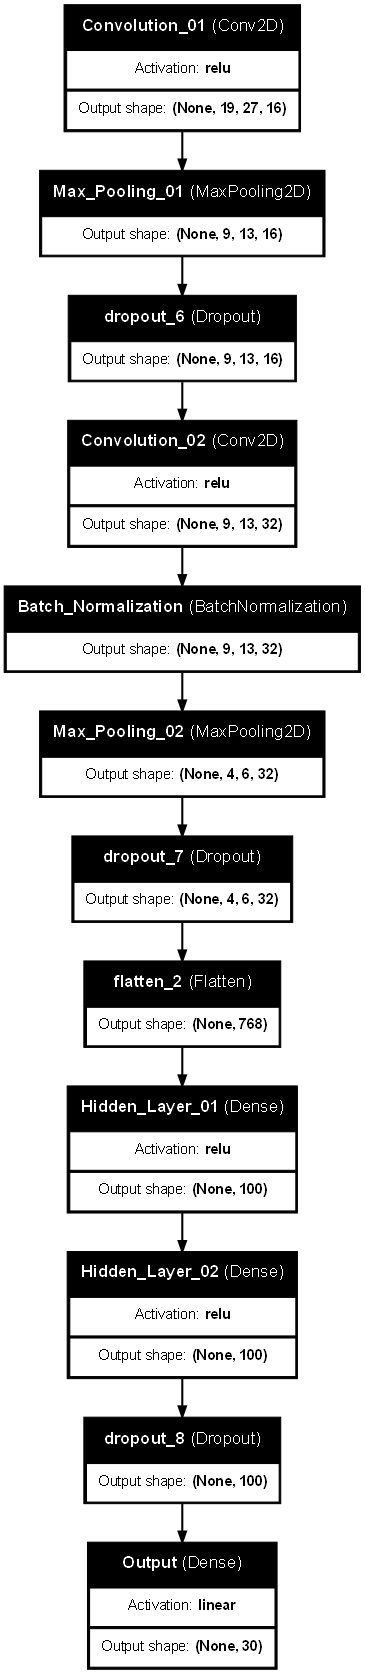

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True,dpi=75)

##### The next step is to compile the model. This is an optimization function, a loss function and performance metric. A good option for the loss function in a regression problem is `mean_squared_error`, metrics allows the user to add aditional functions to monitor training. The optimizer implements the agorithmn which updates the weights of the model.

In [47]:
model.compile(loss = 'mean_squared_error', 
              metrics = ["mean_absolute_error"], 
              optimizer = RMSprop())

## Training the model

##### We'll now train the model for 50 epochs using the `fit()` method upon our built model. We specify:

- `train_atmos`: The training subset of the atmospheric variables
- `train_opg`: The training subset of the observed OPGs
- `batch_size`: The number of samples or observation days used per gradient update.
- `epochs`: The number of full training iterations.
- `validation_data`: The validation subset of the atmospheric variables and observed OPGs

##### This takes a few minutes to train (on my laptop). It's worth remembering what is going on here: the algorithm is reading in batches of 32 images, rescaling them, updating model weights through back propagation and then repeating the whole thing 50 times. As we previously defined a separate validation subset, this routine will calculate two losses:
- The training loss. This is how accurately the model can predict OPG from the atmospheric 'images' that are being used to update the weights
- The validation loss. This is how accurately the model can predict OPG from a set of atmospheric 'images' that are not used in updating the weights

##### As the model continues to train, you should see the loss decrease for both of these, but will likely stabilize at a certain point.

In [48]:
epochs = 50
hist = model.fit(train_atmos, train_opg, # training data
                  batch_size = batch_size,
                  epochs = epochs,                        # epochs
                  validation_data = (val_atmos, val_opg), # validation data
                  verbose = 1)                           # print progress

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9209 - mean_absolute_error: 0.5898 - val_loss: 0.4920 - val_mean_absolute_error: 0.3324
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4088 - mean_absolute_error: 0.3455 - val_loss: 0.4400 - val_mean_absolute_error: 0.3249
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3932 - mean_absolute_error: 0.3379 - val_loss: 0.4336 - val_mean_absolute_error: 0.3258
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3592 - mean_absolute_error: 0.3185 - val_loss: 0.3812 - val_mean_absolute_error: 0.3170
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3613 - mean_absolute_error: 0.3232 - val_loss: 0.3852 - val_mean_absolute_error: 0.3362
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3483 - mean_absolute_error: 0.3163 - val_loss: 0.3968 - val_mean_absolute_error: 0.3339
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3948 - mean_absolute_error: 0.3365 - val_loss: 0.370

##### Now plot the evolution of the loss function and the actual versus predicted OPGs:

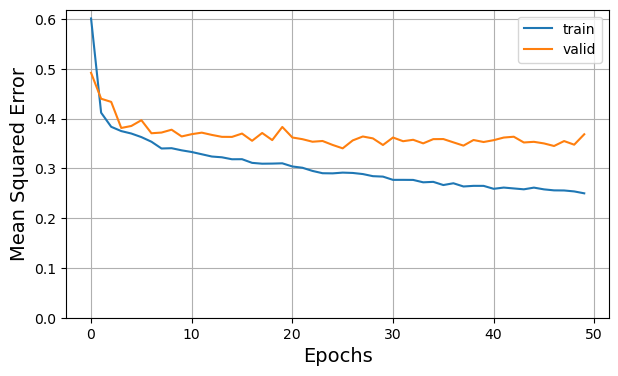

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


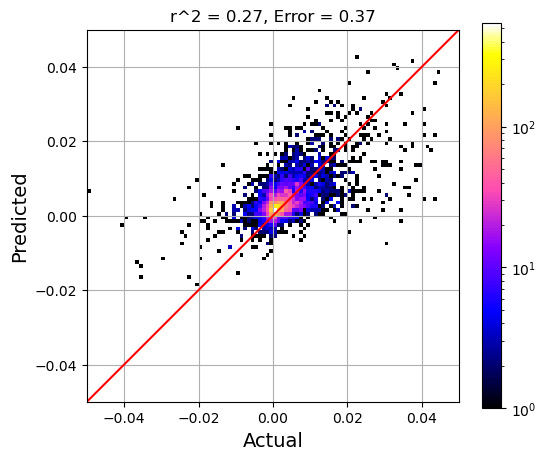

In [49]:
def plot_loss(hist_obs, name):
    # Define label sizes
    label_size = 14
    tick_size = 12
    
    # Create Figure
    plt.figure(figsize=(7, 4))
    plt.plot(hist_obs.history['loss'], label='train')
    plt.plot(hist_obs.history['val_loss'], label='valid')
    plt.xlabel("Epochs", fontsize=label_size)
    plt.ylabel("Mean Squared Error", fontsize=label_size)
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}eval_loss_{name}.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()

def plot_act_pred(modelx, hist_obs, name):
    # Using our fitted model, predict OPGs from the testing subset.
    predicted = modelx.predict(test_atmos)

    # set zero OPGs to nan
    actual = test_opg
    actual[actual==0] = np.nan
    predicted[predicted==0] = np.nan
    
    # Convert from standardized OPG to mm/m OPG
    actual    = (test_opg * opg_std) + opg_mean
    predicted = (predicted * opg_std) + opg_mean
    
    # Lets reshape our OPGs and remove NaN OPG days
    actual    = np.reshape(actual, -1)
    predicted = np.reshape(predicted, -1)
    idx       = np.isnan(actual) # Identify days with OPG observations
    actual    = actual[idx==False]
    predicted = predicted[idx==False]
    
    # Formulate the x and y axis limits
    max_val = np.max((np.max(predicted[:]), np.max(actual[:])))
    min_val = np.min((np.min(predicted[:]), np.min(actual[:])))
    max_val = 0.05
    min_val = -0.05
    
    # Define plot colormap
    cmap_gnuplot2 = ncm.cmap("MPL_gnuplot2")
    
    # Define label sizes
    label_size = 14
    tick_size = 12
    
    # Create Figure
    plt.figure(figsize=(6, 5))
    
    # Formulate the heatmap variables
    heatmap, xedges, yedges = np.histogram2d(np.reshape(actual, -1), np.reshape(predicted, -1), bins=100,
                                 range=[[min_val, max_val],[min_val, max_val]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Plot heatmap
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap_gnuplot2, norm=colors.LogNorm())

    # Plot One-to-one line
    plt.plot([xedges[0], xedges[-1]], [yedges[0], yedges[-1]], c='red')

    # corr
    corr = np.round(np.corrcoef(actual, predicted)[0,1]**2 , 2)
    last_mse = np.round(hist_obs.history['val_loss'][-1], 2)
    
    # Add labels, gridlines, and colorbar
    plt.xlabel("Actual", fontsize=label_size)
    plt.ylabel("Predicted", fontsize=label_size)
    plt.title("r^2 = " + str(corr) + ", Error = " + str(last_mse))
    plt.grid(True)
    plt.colorbar()

    # Save and show figure
    path = "../figures/"
    plt.savefig(f"{path}eval_act_pred_{name}.png", dpi=200, transparent=True,  bbox_inches='tight')
    plt.show()


plot_loss(hist, 'model_01')
plot_act_pred(model, hist, 'model_01')

##### The plot shows a steep decline in both loss values, but no real improvement in the validation loss beyond epoch 20. It's quite likely that this model has overfit - become too tuned to the training data to allow prediction. There are a variety of ways we can avoid this, but a simple one is to slow the rate at which the model learns. We'll refit the model, but will add a `learning_rate` parameter to the compilation step. 

##### Additionally, `callbacks` can be added to the fitting process, in which the fit algorithm will monitor the validation loss. Here, when the validation loss does not improve after 5 epochs, the model stops training.

In [50]:
model = create_model()

model.compile(loss = 'mean_squared_error', 
              metrics = ["mean_absolute_error"], 
              optimizer = RMSprop(learning_rate=1e-4))

callback = [EarlyStopping(monitor='val_loss', patience=5, mode='min')]

epochs = 100
hist = model.fit(train_atmos, train_opg, # training data
                  batch_size = batch_size,
                  epochs = epochs,                        # epochs
                  validation_data = (val_atmos, val_opg), # validation data
                  callbacks=[callback],                   # patience
                  verbose = 1)                           # print progress

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4510 - mean_absolute_error: 0.8761 - val_loss: 0.5120 - val_mean_absolute_error: 0.3690
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7577 - mean_absolute_error: 0.5945 - val_loss: 0.5045 - val_mean_absolute_error: 0.3626
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5790 - mean_absolute_error: 0.4904 - val_loss: 0.4955 - val_mean_absolute_error: 0.3616
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5421 - mean_absolute_error: 0.4463 - val_loss: 0.4846 - val_mean_absolute_error: 0.3601
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5194 - mean_absolute_error: 0.4260 - val_loss: 0.4723 - val_mean_absolute_error: 0.3580
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4658 - mean_absolute_error: 0.3886 - val_loss: 0.4610 - val_mean_absolute_error: 0.3555
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4869 - mean_absolute_error: 0.3930 - val_loss

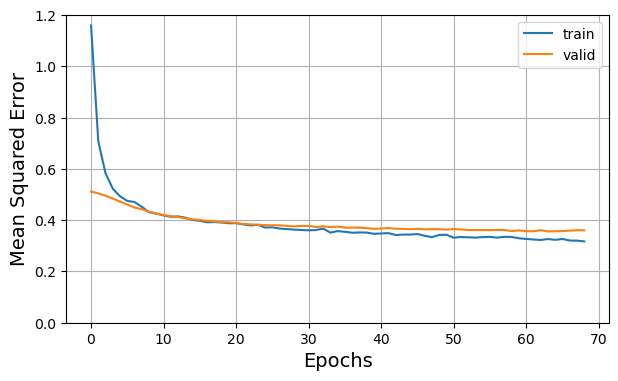

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


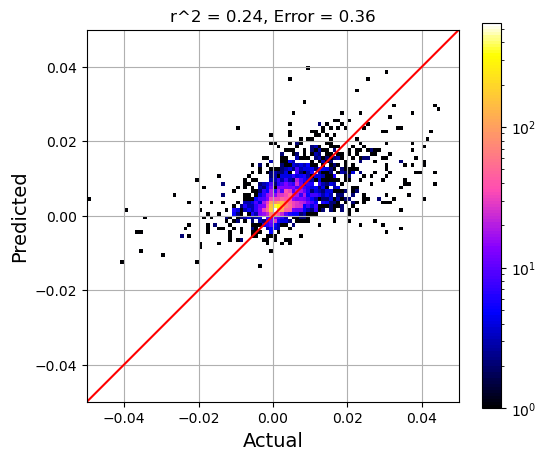

In [51]:
plot_loss(hist, 'model_02_adjust_lr')
plot_act_pred(model, hist, 'model_02_adjust_lr')

##### The plot now shows a good evolution of the loss value.

## How does changing the stucture affect the training outcome?

##### Along with the loss function, the structure of the CNN can be changed. I suggest seeing what happens when you do the following changes individually:
1. `Change the Dense layers to have units=10`
2. `Uncomment the additional MaxPooling2D and Conv2D layers`
3. `Change the loss function to mean_absolute_error`
4. `Set Dropout to zero`

##### Pay mind to how changing these parameters affect the number of parameters to train, how long training time becomes, and the 2D histogram of actual versus predicted OPGs. Feel free to try your own edits to inspect how it affects the testing outcome.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 19, 27, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 13, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 13, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,678 (373.74 KB)

 Trainable params: 95,614 (373.49 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2747 - mean_absolute_error: 0.7881 - mean_squared_error: 1.2749 - val_loss: 0.5092 - val_mean_absolute_error: 0.3735 - val_mean_squared_error: 0.5044
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7325 - mean_absolute_error: 0.5628 - mean_squared_error: 0.7327 - val_loss: 0.4973 - val_mean_absolute_error: 0.3633 - val_mean_squared_error: 0.4925
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5786 - mean_absolute_error: 0.4793 - mean_squared_error: 0.5788 - val_loss: 0.4846 - val_mean_absolute_error: 0.3571 - val_mean_squared_error: 0.4798
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5015 - mean_absolute_error: 0.4317 - mean_squared_error: 0.5017 - val_loss: 0.4720 - val_mean_absolute_error: 0.3537 - val_mean_squared_error: 0.4674
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5124 - mean_absolute_error: 0.4182 - mean_squared_error: 0.5125 - val_loss: 0.4607 - val_mean_absolu

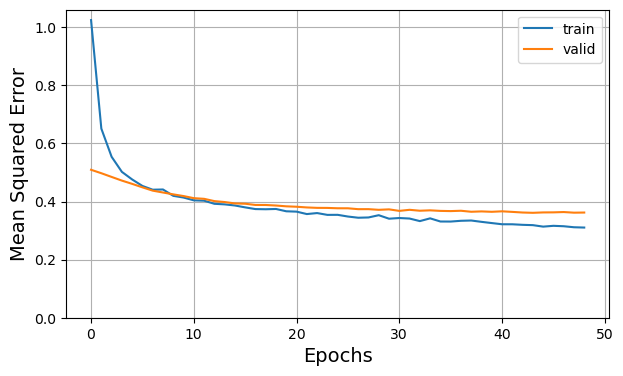

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


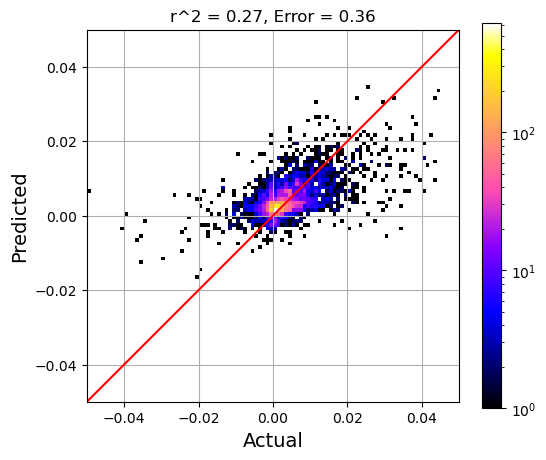

In [55]:
model = Sequential([  
    InputLayer(shape=(latitude, longitude, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    # MaxPooling2D(pool_size = (2,2)),                                                    #2 <-- Comment in this line
    # Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),   #2 <-- Comment in this line
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25),                         #4 <-- Change the dropout from 0.25 to 0.0
    Flatten(),
    Dense(units = 100, activation = 'relu'),  #1 <-- Change the units of the Dense Layers from 100 to 10
    Dense(units = 100, activation = 'relu'),  #1 <-- Change the units of the Dense Layers from 100 to 10
    Dropout(0.25),                         #4 <-- Change the dropout from 0.25 to 0.0
    Dense(units = len(facet_list), activation = 'linear') ])

model.summary()

model.compile(loss = 'mean_squared_error',          #3 <-- Change Loss Function Here from mean_squared_error to mean_absolute_error
              metrics = ["mean_absolute_error", "mean_squared_error"], 
              optimizer = RMSprop(learning_rate=1e-4))

epochs = 80
batch_size = 32

callback = [EarlyStopping(monitor='val_loss', patience=5, mode='min')]

hist = model.fit(train_atmos, train_opg, 
                  batch_size = batch_size,
                  epochs = epochs,                      
                  validation_data = (val_atmos, val_opg),
                  callbacks=[callback],
                  verbose = 1)                     # <-- If you want to silence training, set to 0, if you want to watch it train, set to 1

plot_loss(hist, 'model_03_change_architecture')
plot_act_pred(model, hist, 'model_03_change_architecture')

#### Notice the differences between outputs when changing the hyperparameters:
1. `Change the Dense layers to have units=10`:
  The number of trainable parameters decreases considerably from 95,678 to 13,714. Though the mean squared error reaches a minimum around 80 epochs, the OPG heatmap indicates a decrease in r^2 and an increase in error. Overall, the model is less able to predict more extreme OPGs. Possibiliy from too little parameters? Possibly the patience is too sensitive and it should train for longer?

2. `Uncomment the additional MaxPooling2D and Conv2D layers`:
  Additional MaxPooling2D and Conv2D layers decreased the number of trainable parameters from 95,614 to 75,774. Based on the mean squared error, the model seems to reach a minimum in error somewhere around 60 epochs. The addition of MaxPooling2D and Conv2D layers did not significantly improve or worsen the OPG predictions. More layers don't always improve the model?

3. `Change the loss function to mean_absolute_error`:
  The number of trainable parameters are consistent. Based on the plot of mean absolute error by epoch, the model tends to train very quickly in the beginning and trains slowly until ending. The OPG heatmap shows OPGs are more underpredicted than when using mean_squared_error, most likely due to the loss function. Mean squared error, since it is squared, forces the model to focus more on larger loss values.

4. `Set Dropout to zero`:
   The number of trainable parameters are consistent. Based on the plot of mean squared error by epoch, the model tends to train very quickly, possibly ending before epoch 20. This can cause the model to overfitting to the training data. 
  

#### What you choose for hyperparameters and structure all depends on what your goals are. 